# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from tqdm import tqdm
from glob import glob
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
import tensorflow.lite as tflite


# Data Preparation

In [ ]:
# Constants
RTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\RTM_images'
DTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\DTM_images'
ATM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\ATM_images'

IMG_SIZE = (32, 32)
SEQ_LEN = 5

In [ ]:
# Datasets/
# └── 11G-features/
#     ├── ATM_images/
#     ├── Center_of_Mass/
#     ├── DTM_images/
#     ├── Filtered_Raw_Signals/
#     ├── RFDM_recomputed/
#     │   ├── p0_1/
#     │   │   ├── Circle/
#     │   │   │   ├── sess_0/
#     │   │   │   │   ├── sensor0/
#     │   │   │   │   │   ├── 0.npy
#     │   │   │   │   │   ├── 1.npy
#     │   │   │   │   │   └── ...
#     │   │   │   │   ├── sensor1/
#     │   │   │   │   │   ├── 0.npy
#     │   │   │   │   │   ├── 1.npy
#     │   │   │   │   │   └── ...
#     │   │   │   ├── sess_1/
#     │   │   │   ├── sess_2/
#     │   │   │   ├── sess_3/
#     │   │   │   └── sess_4/
#     │   │   ├── FastSwipeRL/
#     │   │   ├── FingerRub/
#     │   │   ├── FingerSlider/
#     │   │   ├── NoHand/
#     │   │   ├── PalmHold/
#     │   │   ├── PalmTilt/
#     │   │   ├── PinchIndex/
#     │   │   ├── PinchPinkky/
#     │   │   ├── Pull/
#     │   │   ├── Push/
#     │   │   ├── RandomGesture/
#     │   │   └── SlowSwipeRL/
#     │   ├── p0_2/
#     │   ├── p0_3/
#     │   ├── ...
#     │   ├── p0_20/
#     │   ├── p1/
#     │   ├── ...
#     │   └── p25/
#     ├── RTM_images/
#     ├── Signal_Energy_SOR/
#     ├── Signal_Energy_SOT/
#     ├── Signal_Variation_2D/
#     ├── Signal_Variation_SOR/
#     └── Signal_Variation_SOT/

In [3]:
# Function to load image and resize to 28x28x3
def load_and_resize_image(path):
    # img = load_img(path, target_size=(32, 32))
    # return img_to_array(img) / 255.0
    img = load_img(path, color_mode='grayscale', target_size=IMG_SIZE)
    return img_to_array(img).astype(np.uint8)

# Index data correctly with session under person -> session -> gesture
def index_multi_image_sequences(rtm_path, dtm_path, atm_path, seq_len=5, exclude_participants=None):
    all_train_samples, test_samples = [], []
    gesture_set = set()
    exclude_participants = set(exclude_participants or [])

    participants = sorted([p for p in os.listdir(rtm_path) if os.path.isdir(os.path.join(rtm_path, p))])  

    for person in participants:
        # print(f"Processing participant: {person}")
        is_test_person = person in exclude_participants
        rtm_person_path = os.path.join(rtm_path, person)

        for session in os.listdir(rtm_person_path):
            rtm_sess_path = os.path.join(rtm_person_path, session)
            if not os.path.isdir(rtm_sess_path):
                continue

            for gesture in os.listdir(rtm_sess_path):
                rtm_gesture_path = os.path.join(rtm_sess_path, gesture)
                dtm_gesture_path = os.path.join(dtm_path, person, session, gesture)
                atm_gesture_path = os.path.join(atm_path, person, session, gesture)

                if not all(map(os.path.isdir, [rtm_gesture_path, dtm_gesture_path, atm_gesture_path])):
                    continue

                gesture_set.add(gesture)

                rtm_files = sorted(glob(os.path.join(rtm_gesture_path, '*.png')))
                dtm_files = sorted(glob(os.path.join(dtm_gesture_path, '*.png')))
                atm_files = sorted(glob(os.path.join(atm_gesture_path, '*.png')))

                num_frames = min(len(rtm_files), len(dtm_files), len(atm_files))
                for i in range(num_frames - seq_len + 1):
                    sample = {
                        'rtm': rtm_files[i:i+seq_len],
                        'dtm': dtm_files[i:i+seq_len],
                        'atm': atm_files[i:i+seq_len],
                        'label': gesture
                    }
                    if is_test_person:
                        test_samples.append(sample)
                    else:
                        all_train_samples.append(sample)

    # 80/20 train/val split
    train_samples, val_samples = train_test_split(
        all_train_samples, test_size=0.2, random_state=42, shuffle=True
    )

    label_map = {gesture: idx for idx, gesture in enumerate(sorted(gesture_set))}
    return train_samples, val_samples, test_samples, label_map

# DataLoader
class MultiRadarSequenceGenerator(Sequence):
    def __init__(self, samples, label_map, batch_size=32, seq_len=SEQ_LEN, shuffle_data=False):
        self.samples = samples
        self.label_map = label_map
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle_data = shuffle_data
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        batch_samples = self.samples[index * self.batch_size:(index + 1) * self.batch_size]
        X_rtm, X_dtm, X_atm, y = self.__load_batch(batch_samples)
        return [X_rtm, X_dtm, X_atm], y

    def on_epoch_end(self):
        if self.shuffle_data:
            self.samples = shuffle(self.samples)

    def __load_batch(self, batch_samples):
        X_rtm, X_dtm, X_atm, y = [], [], [], []
        for sample in batch_samples:
            try:
                rtm_seq = [load_and_resize_image(p) for p in sample['rtm']]
                dtm_seq = [load_and_resize_image(p) for p in sample['dtm']]
                atm_seq = [load_and_resize_image(p) for p in sample['atm']]
                if len(rtm_seq) == self.seq_len:
                    X_rtm.append(rtm_seq)
                    X_dtm.append(dtm_seq)
                    X_atm.append(atm_seq)
                    y.append(self.label_map[sample['label']])
            except Exception as e:
                print(f"Error loading sample: {e}")
        return (
            np.array(X_rtm),
            np.array(X_dtm),
            np.array(X_atm),
            np.array(y)
        )

In [4]:
# Index sequences
excluded = {f'p0_{i}' for i in range(15, 21)}  # p0_15 to p0_20
train_samples, val_samples, test_samples, label_map = index_multi_image_sequences(
    RTM_PATH, DTM_PATH, ATM_PATH, seq_len=5, exclude_participants=excluded
)

# Create generators
train_gen = MultiRadarSequenceGenerator(train_samples, label_map, batch_size=256, shuffle_data=True)
val_gen = MultiRadarSequenceGenerator(val_samples, label_map, batch_size=256, shuffle_data=False)
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,  # Can use smaller batch size for inference
    seq_len=SEQ_LEN,
    shuffle_data=False  # Important: keep False for consistent evaluation
)

In [5]:
# how many train samples are there?
print(f"Number of training samples: {len(train_samples)}")
# how many test samples are there?
print(f"Number of val samples: {len(val_samples)}")
# how many test samples are there?
print(f"Number of test samples: {len(test_samples)}")
# what is the shape of the sample?
print(f"Shape of a single sample: {train_gen[0][0][0].shape}")

Number of training samples: 6489
Number of val samples: 1623
Number of test samples: 1166
Shape of a single sample: (256, 5, 32, 32, 1)


# Model - Smaller

Reduced CNN filters from 16→8

Replaced regular Conv2D with Depthwise Separable Conv

Used GlobalAveragePooling instead of Flatten+Dense

Reduced LSTM units from 128→32

In [8]:
from tensorflow.keras import Input
def build_compact_cnn(input_shape=(32, 32, 1)):
    input_layer = Input(shape=input_shape)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.DepthwiseConv2D(3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)  # Shape: (None, C)
    return models.Model(inputs=input_layer, outputs=x)

def build_small_multi_cnn_conv1d(seq_len=5, img_shape=(32, 32, 1), num_classes=11):
    # Inputs
    rtm_input = Input(shape=(seq_len, *img_shape), name="rtm_input")
    dtm_input = Input(shape=(seq_len, *img_shape), name="dtm_input")
    atm_input = Input(shape=(seq_len, *img_shape), name="atm_input")

    cnn_encoder = build_compact_cnn(img_shape)

    # Encode each frame (time-distributed CNN feature extractor)
    encoded = [
        layers.TimeDistributed(cnn_encoder)(modality_input) 
        for modality_input in [rtm_input, dtm_input, atm_input]
    ]  # Each is shape (batch, seq_len, features)

    # Concatenate across features: (batch, seq_len, total_features)
    merged = layers.Concatenate(axis=-1)(encoded)

    # Temporal modeling with SeparableConv1D (STM32-safe)
    x = layers.SeparableConv1D(32, kernel_size=3, padding="same", activation='relu')(merged)
    x = layers.GlobalAveragePooling1D()(x)  # (batch, 32)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=[rtm_input, dtm_input, atm_input], outputs=output)


# Training and Validation

In [9]:
class BatchCheckpoint(Callback):
    def __init__(self, save_dir, label_map, every_n_batches=100):
        super().__init__()
        self.save_dir = save_dir
        self.every_n_batches = every_n_batches
        self.batch_count = 0
        self.label_map = label_map
        os.makedirs(save_dir, exist_ok=True)

    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.every_n_batches == 0:
            filename = os.path.join(self.save_dir, f"batch_{self.batch_count:06d}.h5")
            self.model.save(filename, save_format="tf")
            print(f"Saved model at batch {self.batch_count} to {filename}")

class TQDMProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_gen):
        super().__init__()
        self.test_gen = test_gen

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_pbar = tqdm(total=1, desc=f"Epoch {epoch+1}", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_pbar.update(1)
        self.epoch_pbar.close()
        loss, acc = self.model.evaluate(self.test_gen, verbose=0)
        print(f"Epoch {epoch+1}: Test Accuracy = {acc:.4f}")
                    
class SaveLossAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, filepath='training_log.txt'):
        super().__init__()
        self.filepath = filepath
        with open(self.filepath, 'w') as f:
            f.write("epoch,loss,accuracy,val_loss,val_accuracy\n")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        line = f"{epoch+1},{logs.get('loss'):.4f},{logs.get('accuracy'):.4f},{logs.get('val_loss'):.4f},{logs.get('val_accuracy'):.4f}\n"
        with open(self.filepath, 'a') as f:
            f.write(line)

In [ ]:
model = build_small_multi_cnn_conv1d(num_classes=len(label_map))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = ModelCheckpoint(
    filepath='Models/3_radar_CNN_c1d/qat_small_model_epoch{epoch:02d}_valacc{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

batch_checkpoint_cb = BatchCheckpoint(
    save_dir='Models/3_radar_CNN_v2_c1d/qat_batch_checkpoints',
    label_map=label_map,
    every_n_batches=2500
)

log_callback = SaveLossAccuracy(r"\Code\model_training_grayscale_images\Models\3_radar_CNN_v2\qat_training_log.txt")

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, 
    callbacks=[
        TQDMProgressCallback(val_gen),
        checkpoint_cb,
        batch_checkpoint_cb,
        log_callback
    ],
    workers=1,
    use_multiprocessing=False,
)
model.save("Models/3_radar_CNN_v2_c1d/final_training_model.h5", save_format="tf")

In [26]:
model.summary()
# i wanna know the size in mb
model_size = model.count_params() * 4 / (1024 * 1024)  # Assuming 4 bytes per float32
print(f"Model size: {model_size:.4f} MB")

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rtm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 dtm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 atm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                         

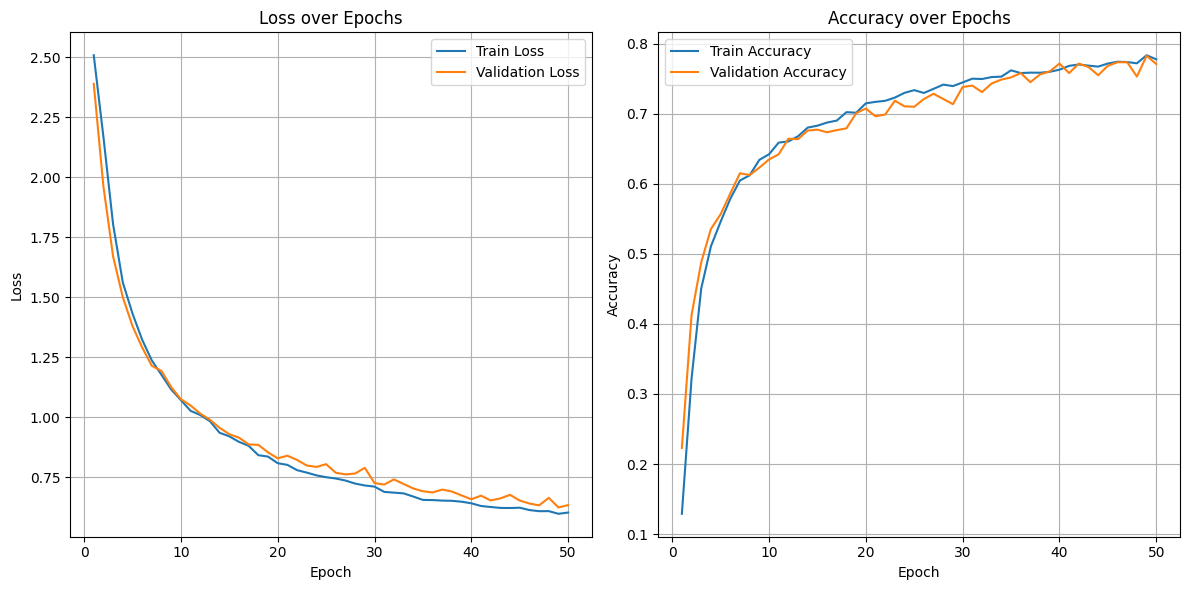

In [ ]:
# Load the training log
log_df = pd.read_csv(r"\Code\model_training\Models\3_radar_CNN_v2\qat_training_log.txt")#, sep="\t")

# Plot
if 'epoch' not in log_df.columns:
    log_df['epoch'] = range(1, len(log_df) + 1)

# Plot
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(log_df['epoch'], log_df['loss'], label='Train Loss')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(log_df['epoch'], log_df['accuracy'], label='Train Accuracy')
plt.plot(log_df['epoch'], log_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Testing

In [23]:
def plot_confusion_matrix(y_true, y_pred, label_map, title_suffix=""):
    """
    Plots a normalized confusion matrix
    """
    # Invert label_map: index -> gesture name
    inv_label_map = {v: k for k, v in label_map.items()}
    gesture_names = [inv_label_map[i] for i in sorted(inv_label_map)]

    # Compute and normalize confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=gesture_names, yticklabels=gesture_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (%)\n{title_suffix}'.strip())
    plt.tight_layout()
    plt.show()


def print_classification_report(y_true, y_pred, label_map):
    """
    Prints a formatted classification report
    """
    inv_label_map = {v: k for k, v in label_map.items()}
    gesture_names = [inv_label_map[i] for i in sorted(inv_label_map)]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=gesture_names,
                                digits=4))


In [ ]:
# Load the QAT-trained model (not yet converted to TFLite)
qat_model_path = r'\Code\model_training\Models\3_radar_CNN_v2\qat_small_model_epoch49_valacc0.7825.h5'
qat_model = tf.keras.models.load_model(
    qat_model_path,
    custom_objects={
        'QuantizeAnnotate': quantize_annotate_layer,
        'quantize_annotate_layer': quantize_annotate_layer
    }
)
# Initialize test generator (same as before)
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

# Evaluate full model
test_loss, test_acc = qat_model.evaluate(test_gen)
print(f"QAT Model Test Accuracy: {test_acc:.4f}")

37/37 [==============================] - 5s 117ms/step - loss: 0.4796 - accuracy: 0.8122
QAT Model Test Accuracy: 0.8122


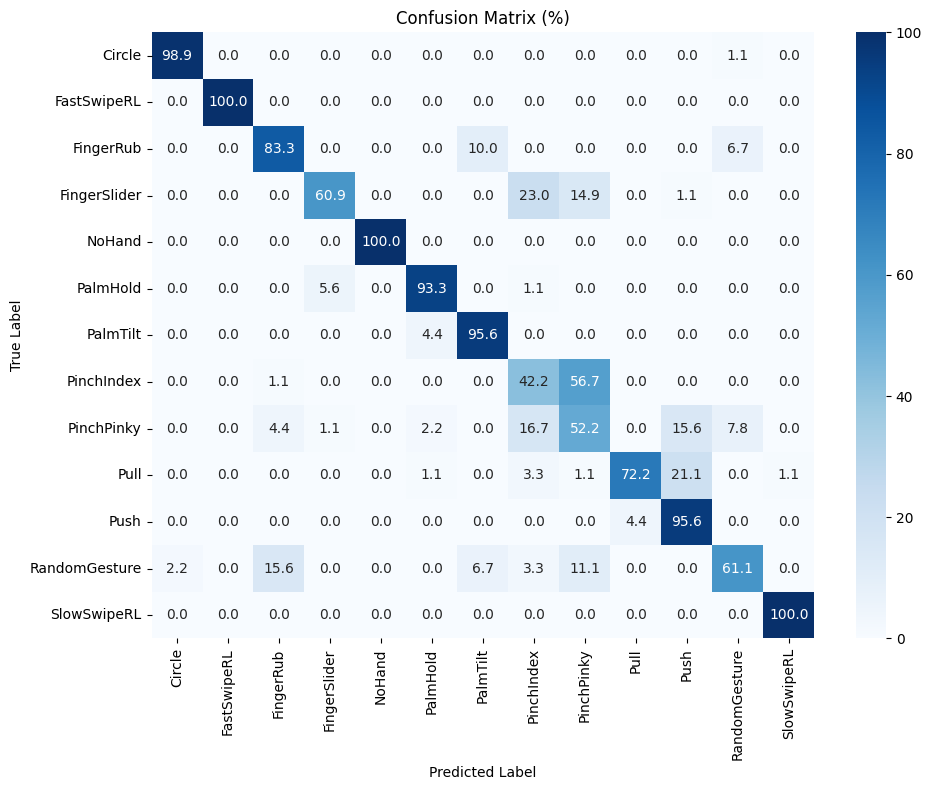


Classification Report:
               precision    recall  f1-score   support

       Circle     0.9780    0.9889    0.9834        90
  FastSwipeRL     1.0000    1.0000    1.0000        90
    FingerRub     0.7979    0.8333    0.8152        90
 FingerSlider     0.8983    0.6092    0.7260        87
       NoHand     1.0000    1.0000    1.0000        90
     PalmHold     0.9222    0.9326    0.9274        89
     PalmTilt     0.8515    0.9556    0.9005        90
   PinchIndex     0.4750    0.4222    0.4471        90
   PinchPinky     0.3852    0.5222    0.4434        90
         Pull     0.9420    0.7222    0.8176        90
         Push     0.7167    0.9556    0.8190        90
RandomGesture     0.7971    0.6111    0.6918        90
  SlowSwipeRL     0.9890    1.0000    0.9945        90

     accuracy                         0.8122      1166
    macro avg     0.8272    0.8118    0.8128      1166
 weighted avg     0.8269    0.8122    0.8129      1166



In [24]:
# Generate predictions
y_true = []
y_pred = []

for X, y in test_gen:
    preds = qat_model.predict(X, verbose=0)
    y_true.extend(y)
    y_pred.extend(np.argmax(preds, axis=1))

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate and plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_map)
print_classification_report(y_true, y_pred, label_map)

# Test TFLite Conversion

In [ ]:
best_model_path = r'\Code\model_training\Models\3_radar_CNN_v2\qat_small_model_epoch49_valacc0.7825.h5'

In [ ]:
model = tf.keras.models.load_model(best_model_path)

# Wrap in tf.function with input signature
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="rtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="dtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="atm_input")
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

concrete_func = wrapped_model.get_concrete_function()

# TFLite converter from concrete function
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

with open("your_model_float32_fixed.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model (float32 with LSTM fix) saved!")

In [ ]:
interpreter = tf.lite.Interpreter(model_path=r"\Code\model_training\your_model_float32_fixed.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [140]:
for i, d in enumerate(input_details):
    print(f"Input {i}: shape={d['shape']}, dtype={d['dtype']}, quant={d['quantization']}")

for i, d in enumerate(output_details):
    print(f"Output {i}: shape={d['shape']}, dtype={d['dtype']}, quant={d['quantization']}")


Input 0: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Input 1: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Input 2: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Output 0: shape=[ 1 13], dtype=<class 'numpy.float32'>, quant=(0.0, 0)


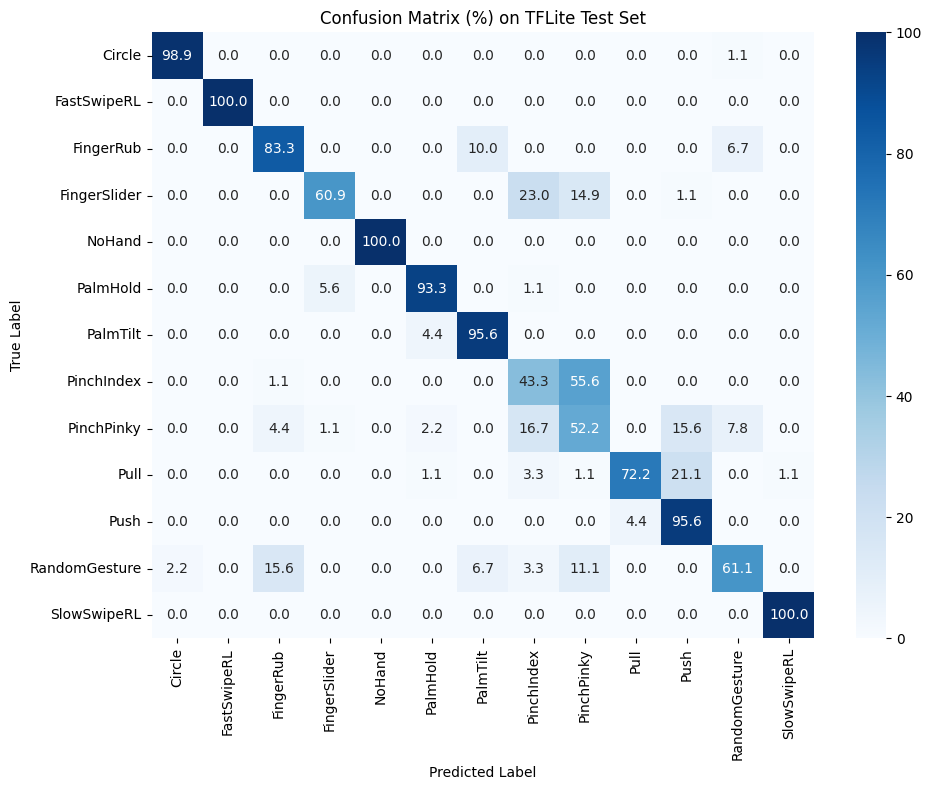

               precision    recall  f1-score   support

       Circle       0.98      0.99      0.98        90
  FastSwipeRL       1.00      1.00      1.00        90
    FingerRub       0.80      0.83      0.82        90
 FingerSlider       0.90      0.61      0.73        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       0.92      0.93      0.93        89
     PalmTilt       0.85      0.96      0.90        90
   PinchIndex       0.48      0.43      0.46        90
   PinchPinky       0.39      0.52      0.45        90
         Pull       0.94      0.72      0.82        90
         Push       0.72      0.96      0.82        90
RandomGesture       0.80      0.61      0.69        90
  SlowSwipeRL       0.99      1.00      0.99        90

     accuracy                           0.81      1166
    macro avg       0.83      0.81      0.81      1166
 weighted avg       0.83      0.81      0.81      1166



In [141]:
def run_tflite_inference(rtm, dtm, atm):
    interpreter.set_tensor(input_details[0]['index'], rtm.astype(input_details[0]['dtype']))
    interpreter.set_tensor(input_details[1]['index'], dtm.astype(input_details[1]['dtype']))
    interpreter.set_tensor(input_details[2]['index'], atm.astype(input_details[2]['dtype']))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Collect predictions
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = X_batch[0].shape[0]
    for i in range(batch_size):
        rtm = X_batch[0][i:i+1] # shape: (1, 5, 32, 32, 3)
        dtm = X_batch[1][i:i+1] 
        atm = X_batch[2][i:i+1] 
        output = run_tflite_inference(rtm, dtm, atm)
        y_pred.append(np.argmax(output))
        y_true.append(y_batch[i])

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Evaluate: confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
inv_label_map = {v: k for k, v in label_map.items()}
gesture_names = [inv_label_map[i] for i in range(len(inv_label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Test Set')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=gesture_names))

# Quantize float 16

In [ ]:
model = tf.keras.models.load_model(best_model_path)

# Define the wrapped model with fixed input signature
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="rtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="dtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="atm_input")
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

# Get concrete function
concrete_func = wrapped_model.get_concrete_function()

# Create TFLite converter from it
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# Enable float16 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Preserve LSTM compatibility
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Convert
tflite_fp16_model = converter.convert()

# Save
with open("your_model_float16.tflite", "wb") as f:
    f.write(tflite_fp16_model)

print("Float16 TFLite model saved successfully.")

In [ ]:
interpreter = tf.lite.Interpreter(model_path=r"\Code\model_training\your_model_float16.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

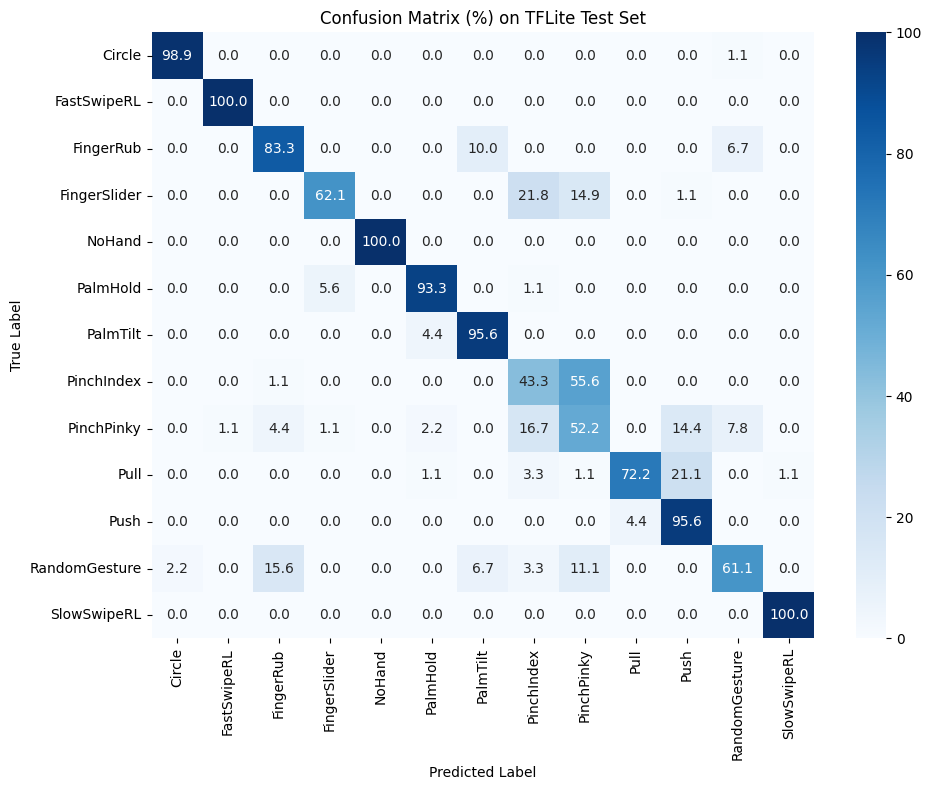

               precision    recall  f1-score   support

       Circle       0.98      0.99      0.98        90
  FastSwipeRL       0.99      1.00      0.99        90
    FingerRub       0.80      0.83      0.82        90
 FingerSlider       0.90      0.62      0.73        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       0.92      0.93      0.93        89
     PalmTilt       0.85      0.96      0.90        90
   PinchIndex       0.49      0.43      0.46        90
   PinchPinky       0.39      0.52      0.45        90
         Pull       0.94      0.72      0.82        90
         Push       0.72      0.96      0.82        90
RandomGesture       0.80      0.61      0.69        90
  SlowSwipeRL       0.99      1.00      0.99        90

     accuracy                           0.81      1166
    macro avg       0.83      0.81      0.81      1166
 weighted avg       0.83      0.81      0.81      1166



In [144]:
def run_tflite_inference(rtm, dtm, atm):
    interpreter.set_tensor(input_details[0]['index'], rtm.astype(input_details[0]['dtype']))
    interpreter.set_tensor(input_details[1]['index'], dtm.astype(input_details[1]['dtype']))
    interpreter.set_tensor(input_details[2]['index'], atm.astype(input_details[2]['dtype']))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Collect predictions
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = X_batch[0].shape[0]
    for i in range(batch_size):
        rtm = X_batch[0][i:i+1] # shape: (1, 5, 32, 32, 3)
        dtm = X_batch[1][i:i+1] 
        atm = X_batch[2][i:i+1] 
        output = run_tflite_inference(rtm, dtm, atm)
        y_pred.append(np.argmax(output))
        y_true.append(y_batch[i])

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Evaluate: confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
inv_label_map = {v: k for k, v in label_map.items()}
gesture_names = [inv_label_map[i] for i in range(len(inv_label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Test Set')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=gesture_names))

# Quantize int 8

In [145]:
def representative_dataset():
    for X_batch, _ in test_gen:
        # Use just a few samples (e.g., 100), and only one input at a time
        for i in range(min(len(X_batch[0]), 100)):
            rtm = X_batch[0][i:i+1].astype(np.float32)
            dtm = X_batch[1][i:i+1].astype(np.float32)
            atm = X_batch[2][i:i+1].astype(np.float32)
            yield [rtm, dtm, atm]


In [ ]:
# Load your original model
model = tf.keras.models.load_model(best_model_path)

# Wrap with tf.function and get concrete function
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="rtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="dtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="atm_input")
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

concrete_func = wrapped_model.get_concrete_function()

# Create TFLite converter
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# Use mixed float input, int8 weights (safe for LSTM)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# To force full integer quantization (including input/output), add:
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

converter._experimental_lower_tensor_list_ops = False  # preserve LSTM

# Convert
tflite_model_int8 = converter.convert()

# Save model
with open("your_model_int8.tflite", "wb") as f:
    f.write(tflite_model_int8)

print("INT8 TFLite model saved successfully.")


In [ ]:
interpreter = tf.lite.Interpreter(model_path=r"\Code\model_training\your_model_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

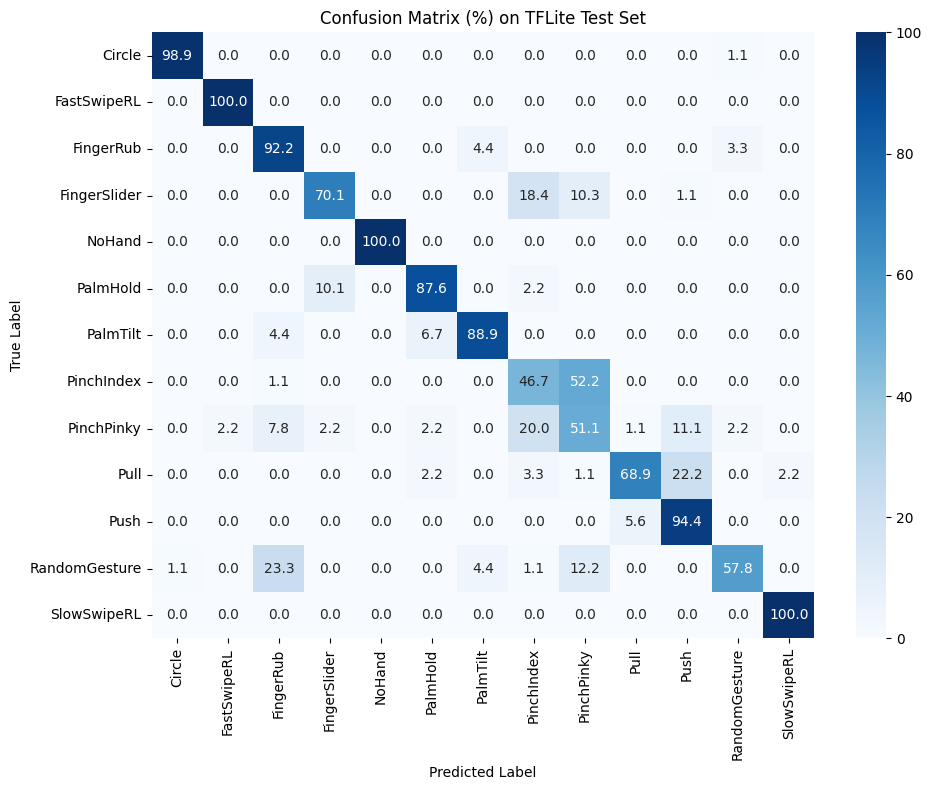

               precision    recall  f1-score   support

       Circle       0.99      0.99      0.99        90
  FastSwipeRL       0.98      1.00      0.99        90
    FingerRub       0.72      0.92      0.81        90
 FingerSlider       0.85      0.70      0.77        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       0.89      0.88      0.88        89
     PalmTilt       0.91      0.89      0.90        90
   PinchIndex       0.51      0.47      0.49        90
   PinchPinky       0.40      0.51      0.45        90
         Pull       0.91      0.69      0.78        90
         Push       0.73      0.94      0.83        90
RandomGesture       0.90      0.58      0.70        90
  SlowSwipeRL       0.98      1.00      0.99        90

     accuracy                           0.81      1166
    macro avg       0.83      0.81      0.81      1166
 weighted avg       0.83      0.81      0.81      1166



In [148]:
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = X_batch[0].shape[0]
    for i in range(batch_size):
        rtm = X_batch[0][i:i+1] # shape: (1, 5, 32, 32, 3)
        dtm = X_batch[1][i:i+1] 
        atm = X_batch[2][i:i+1] 
        output = run_tflite_inference(rtm, dtm, atm)
        y_pred.append(np.argmax(output))
        y_true.append(y_batch[i])

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Evaluate: confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
inv_label_map = {v: k for k, v in label_map.items()}
gesture_names = [inv_label_map[i] for i in range(len(inv_label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Test Set')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=gesture_names))